In [1]:
'''
Vision label swap exps
'''

import importlib
import numpy as np
from tqdm.auto import tqdm
import pickle

import hydra
import logging

from prol.process import (
    get_cycle,
    get_torch_dataset,
    get_task_indicies_and_map,
    get_multi_indices_and_map,
    get_multi_sequence_indices,
    get_sequence_indices,

    get_markov_chain,
    get_markov_sequence_indices
)
from prol.utils import get_dataloader

import torch
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy

import math

## Basic

In [37]:
class SetParams:
    def __init__(self, dict) -> None:
        for k, v in dict.items():
            setattr(self, k, v)

def get_modules(name):
    try: 
        module1 = importlib.import_module(f"prol.models.{name}")
        module2 = importlib.import_module(f"prol.datahandlers.{name}_handle")
    except ImportError:
        print(f"Module {name} not found")
    return module1, module2

In [33]:
log = logging.getLogger(__name__)

logging.basicConfig(filename='dev.log', level=logging.INFO)

# input parameters
params = {
    # dataset
    "dataset": "cifar-10",
    "task": [[0, 1], [2, 3]],    # task specification

    # experiment
    "method": "conv_proformer",         # select from {proformer, cnn, mlp, timecnn}
    "N": 20,                     # time between two task switches                   
    "t": 500,                  # training time
    "T": 5000,                   # future time horizon
    "seed": 1996,   
    "device": "cuda:1",          # device
    "reps": 100,                 # number of test reps
    "outer_reps": 1,         
    
    # proformer
    "proformer" : {
        "contextlength": 200, 
        "encoding_type": 'freq',      
        "multihop": True
    },

    # proformer
    "conv_proformer" : {
        "contextlength": 200, 
        "encoding_type": 'freq',      
        "multihop": True
    },

    # timecnn
    "timecnn": {
        "encoding_type": 'freq', 
    },
            
    # training params
    "lr": 1e-3,         
    "batchsize": 64,
    "epochs": 500,
    "verbose": True
}
args = SetParams(params)
log.info(f'{params}')

# get source dataset
root = '/cis/home/adesilva/ashwin/research/ProL/data'
torch_dataset = get_torch_dataset(root, name=args.dataset)

# get indices for each task
taskInd, maplab = get_task_indicies_and_map(
    tasks=args.task,
    y=torch_dataset.targets.numpy(),
    type='covariate-shift'
)

log.info(" ")
    
# get a training sequence
seed = args.seed * 2357
train_SeqInd, updated_taskInd = get_sequence_indices(
    N=args.N, 
    total_time_steps=args.t, 
    tasklib=taskInd, 
    seed=seed,
    remove_train_samples=True
)


# get the module for the specified method
method, datahandler = get_modules(args.method)

# form the train dataset
data_kwargs = {
    "dataset": torch_dataset, 
    "seqInd": train_SeqInd, 
    "maplab": maplab
}
train_dataset = datahandler.VisionSequentialDataset(args, **data_kwargs)

# # model
# model_kwargs = method.model_defaults(args.dataset)
# if args.method == 'proformer':
#     model_kwargs['encoding_type'] = args.proformer['encoding_type']
# elif args.method == 'timecnn':
#     model_kwargs['encoding_type'] = args.timecnn['encoding_type']
# log.info(f'{model_kwargs}')
# model = method.Model(
#     num_classes=len(args.task[0]),
#     **model_kwargs
# )
    
# # train
# trainer = method.Trainer(model, train_dataset, args)
# trainer.fit(log)

Files already downloaded and verified


In [34]:
# import matplotlib.pyplot as plt
# for data, lab in zip(torch_dataset.data[train_SeqInd[:30]], torch_dataset.targets[train_SeqInd[:30]]):
#     plt.imshow(data.squeeze())
#     plt.title(f'label = {lab}')
#     plt.show()

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms

In [36]:
root = '/cis/home/adesilva/ashwin/research/ProL/data'
dataset = torchvision.datasets.CIFAR10(
            root=root,
            train=True,
            download=True
        )

Files already downloaded and verified


## Multi-task, Mulit-Class

In [18]:
class SetParams:
    def __init__(self, dict) -> None:
        for k, v in dict.items():
            setattr(self, k, v)

# input parameters
params = {
    # dataset
    "dataset": "mnist",
    "task": [[0, 1, 2], [2, 0], [3, 2, 0, 1]],    # task specification

    # experiment
    "method": "proformer",         # select from {proformer, cnn, mlp, timecnn}
    "N": 10,                     # time between two task switches                   
    "t": 500,                  # training time
    "T": 5000,                   # future time horizon
    "seed": 1996,   
    "device": "cuda:1",          # device
    "reps": 100,                 # number of test reps
    "outer_reps": 3,         
    
    # proformer
    "proformer" : {
        "contextlength": 200, 
        "encoding_type": 'vanilla',      
        "multihop": False
    },

    # conv_proformer
    "conv_proformer" : {
        "contextlength": 100, 
        "encoding_type": 'freq',      
        "multihop": True
    },

    # timecnn
    "timecnn": {
        "encoding_type": 'freq', 
    },
            
    # training params
    "lr": 1e-3,         
    "batchsize": 64,
    "epochs": 300,
    "verbose": True
}
args = SetParams(params)

In [27]:
tasks = [
    [0, 1, 2], [1, 2, 3], [2, 3, 4]
]

root = '/cis/home/adesilva/ashwin/research/ProL/data'
torch_dataset = get_torch_dataset(root, 'mnist')

taskInd, maplab, torch_dataset = get_multi_indices_and_map(tasks, torch_dataset)

In [19]:
# get total indices

N = 10
t_list = [100,200,500,700,1000,1200,1500,1700,2000,2500]
T = 5000
initial_seed = 1996

outer_reps = 3
reps = 100

total_indices = {}
for t in t_list:
    print(f't = {t}')
    replicates = []
    for outer_rep in range(outer_reps):
        seed = initial_seed * outer_rep * 2357
        train_SeqInd, updated_taskInd = get_multi_sequence_indices(
            N=N, 
            total_time_steps=t, 
            tasklib=taskInd, 
            seed=seed,
            remove_train_samples=True
        )

        test_seqInds = [
            get_sequence_indices(N, T, updated_taskInd, seed=seed+1000*(inner_rep+1))
            for inner_rep in range(reps)
        ]
        seq = {}
        seq['train'] = train_SeqInd
        seq['test'] = test_seqInds
        replicates.append(seq)
    total_indices[t] = replicates

t = 100
t = 200
t = 500
t = 700
t = 1000
t = 1200
t = 1500
t = 1700
t = 2000
t = 2500


In [5]:
file = '/home/ubuntu/ProL/experiments/vision_multi/indices/mnist_00-51-47.pkl'
with open(file, 'rb') as f:
    outputs = pickle.load(f)

In [6]:
tasks = [
    [0, 1, 2], [1, 2, 3], [2, 3, 4]
]

In [8]:
root = '../data'
torch_dataset = get_torch_dataset(root, 'mnist')

In [9]:
taskInd, maplab, torch_dataset = get_multi_indices_and_map(tasks, torch_dataset)

In [11]:
print([len(taskInd[i]) for i in list(taskInd.keys())])

[11280, 8422, 10894]


In [18]:
train = outputs[500][0]['train']

In [22]:
test = outputs[500][0]['test'][0][500:]

In [23]:
len(test)

4500

In [24]:
torch_dataset.targets[test]

tensor([18, 17, 18,  ..., 14, 15, 14])

In [17]:
def get_cycle(N, num_tasks):
    flags = np.arange(num_tasks)
    unit = []
    for flag in flags:
        unit += [flag] * N
    return unit

In [18]:
total_time_steps = 100
N = 10
num_tasks = len(tasks)
remove_train_samples = True

In [19]:
print([len(tasklib[i]) for i in range(num_tasks)])

[7331, 3960, 13463]


In [24]:
len(tasklib)

3

In [1]:
from datetime import datetime

In [6]:
dataset = 'mnist'
f'{dataset}_{datetime.now().strftime("%H-%M-%S")}'

'mnist_15-59-42'

In [20]:
tasklib = deepcopy(tasklib)
unit = get_cycle(N, num_tasks)
pattern = np.array((unit * math.ceil(total_time_steps/(len(unit))))[:total_time_steps]).astype("int")
seqInd = np.zeros((total_time_steps,)).astype('int')

np.random.seed(1996)
for taskid in range(num_tasks):
    seqInd[pattern==taskid] = np.random.choice(tasklib[taskid], sum(pattern==taskid), replace=False)

if remove_train_samples:
    for taskid in range(num_tasks):
        tasklib[taskid] = list(
            set(tasklib[taskid]) - set(tasklib[taskid]).intersection(seqInd)
        ) 

In [21]:
print([len(tasklib[i]) for i in range(num_tasks)])

[7291, 3930, 13433]


In [8]:
pattern

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

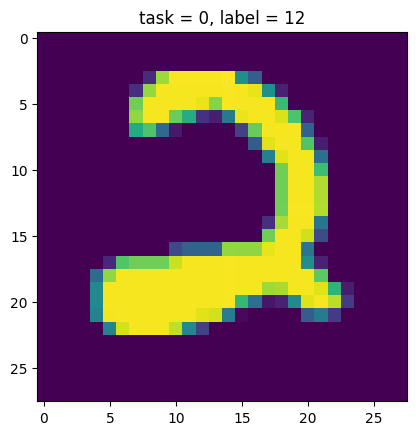

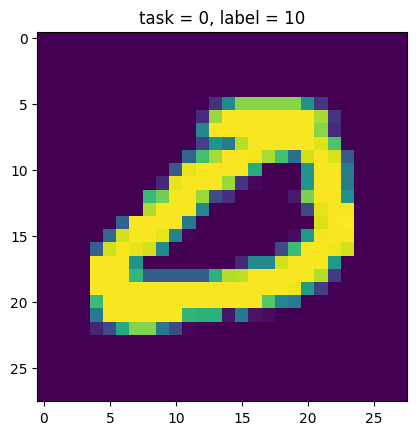

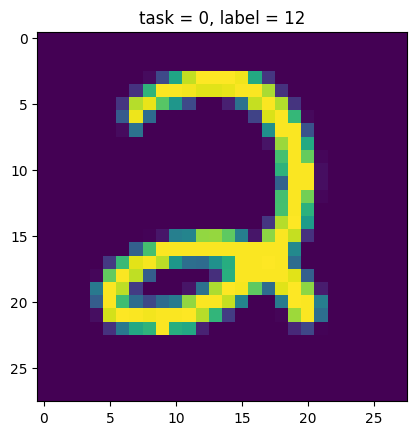

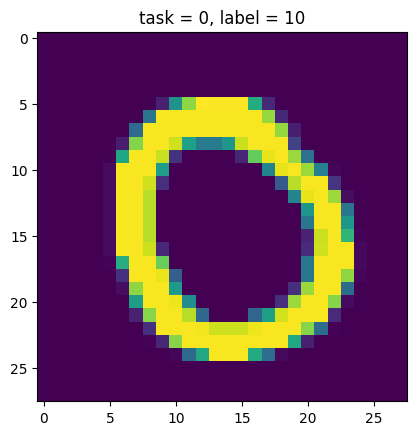

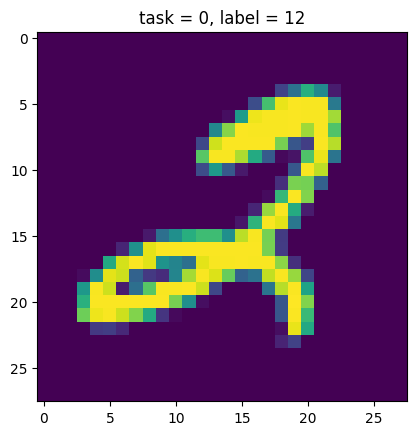

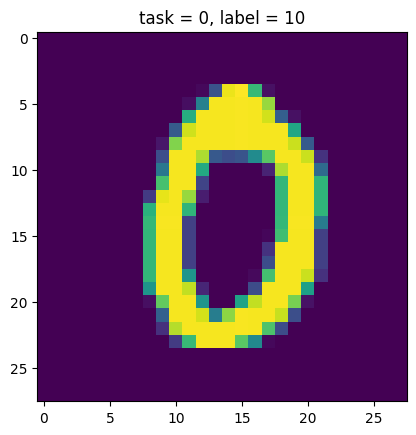

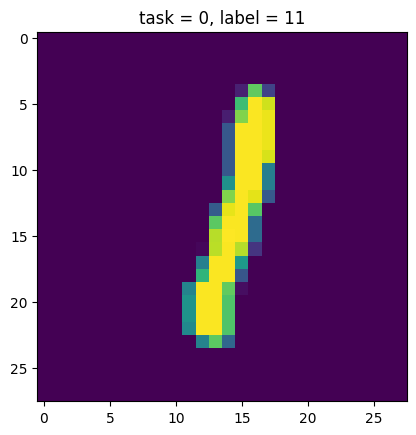

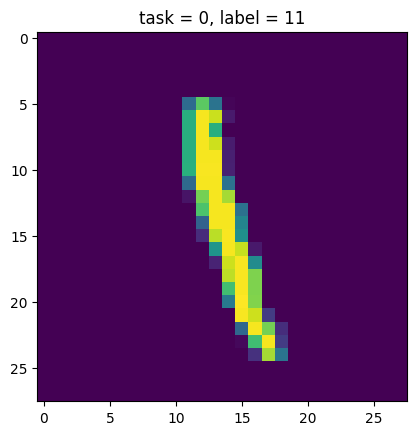

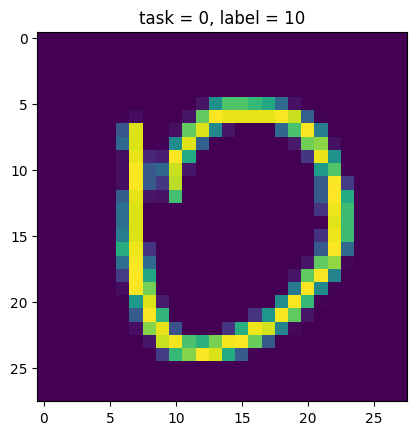

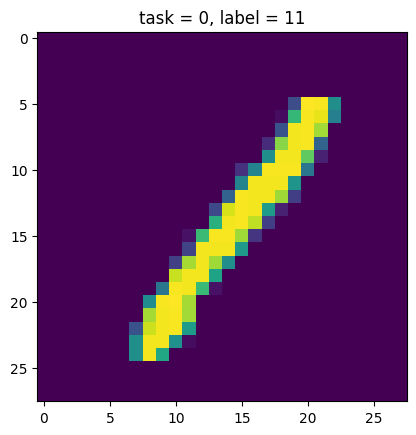

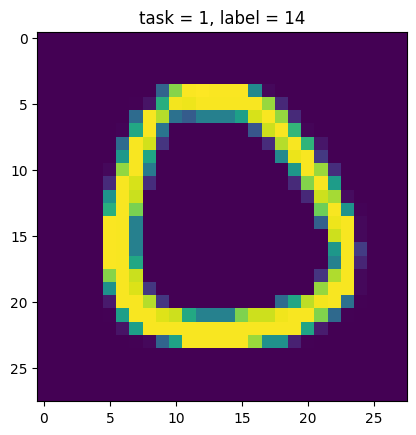

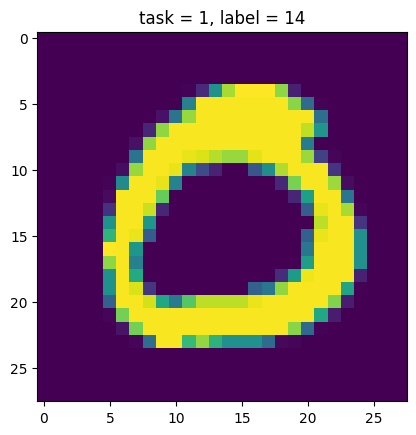

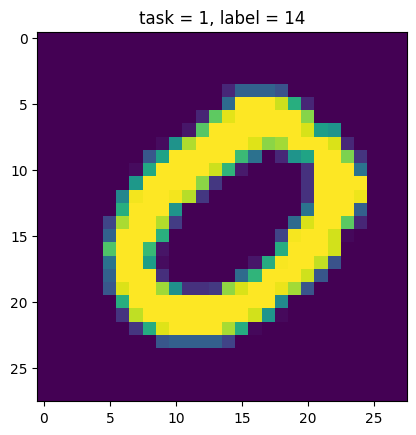

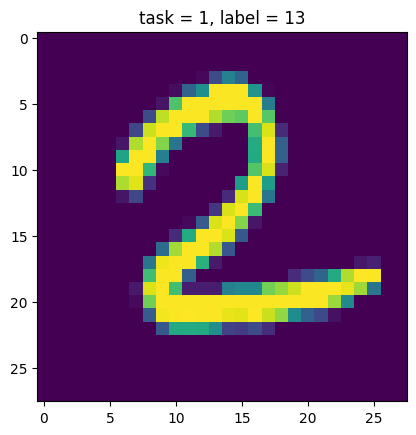

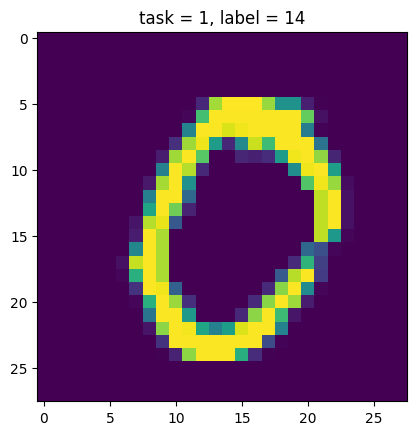

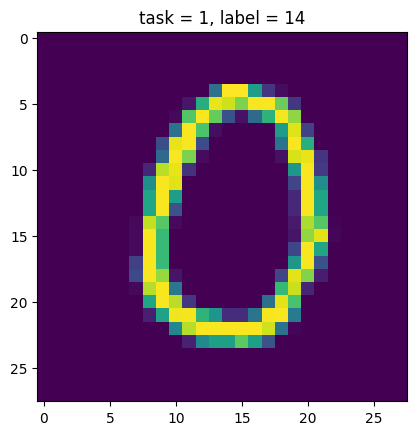

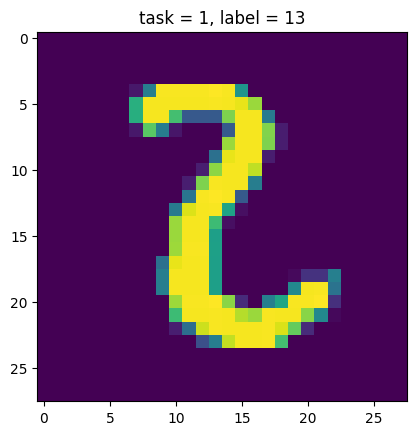

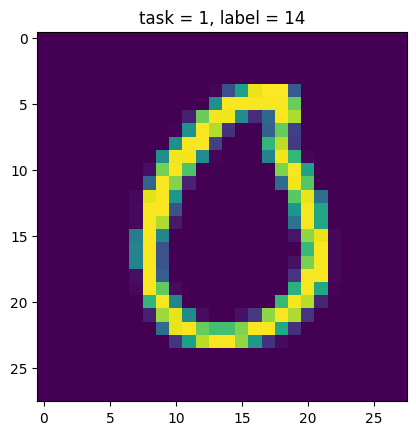

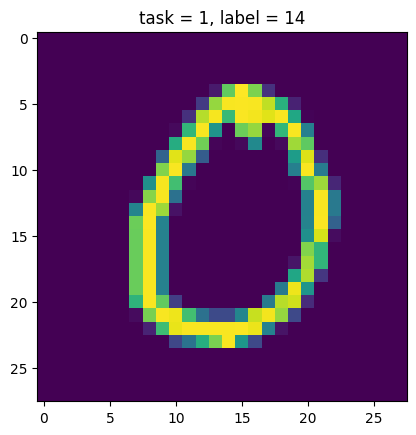

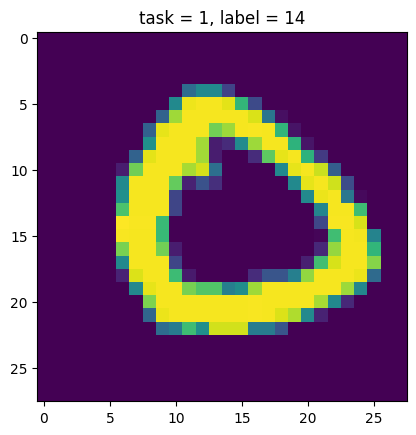

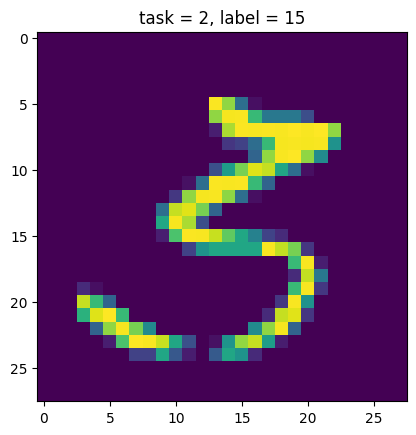

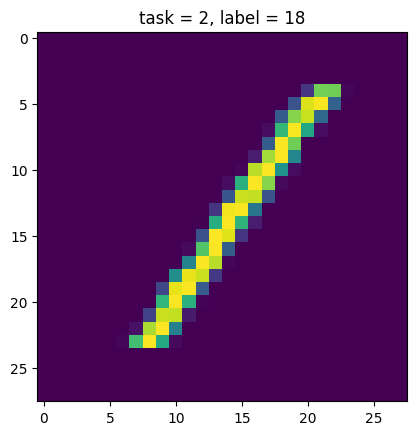

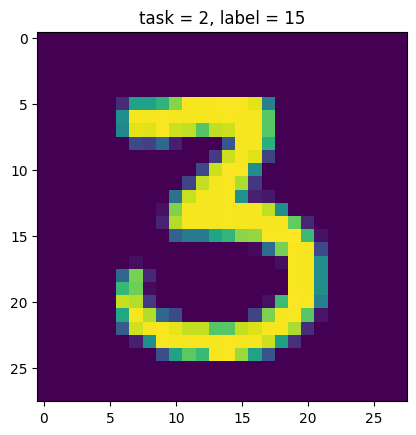

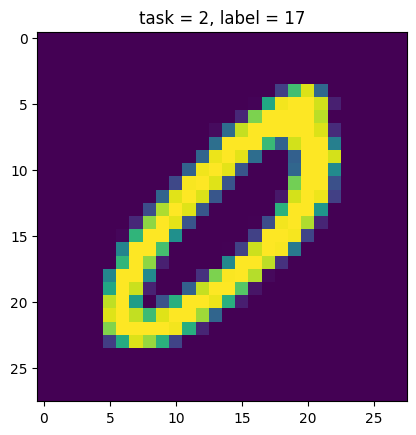

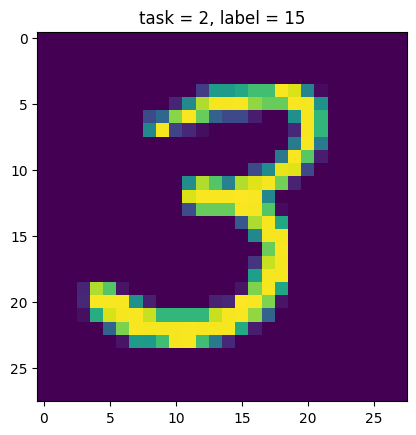

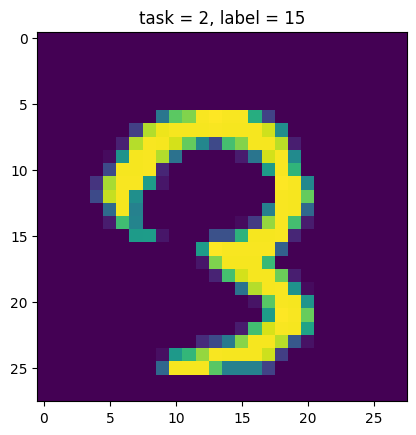

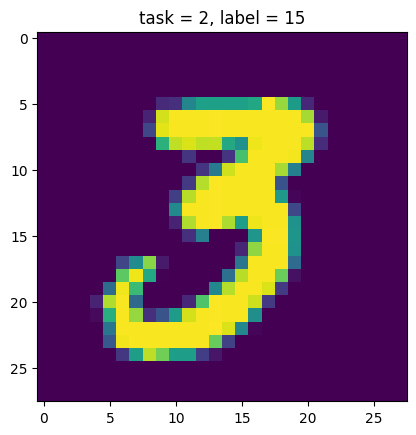

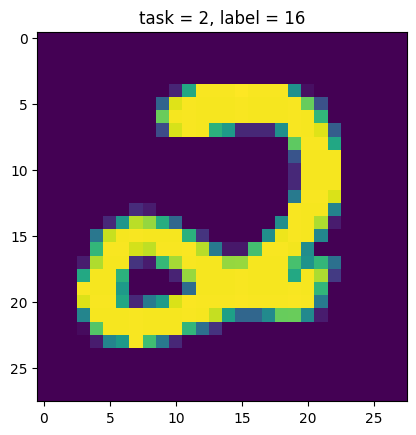

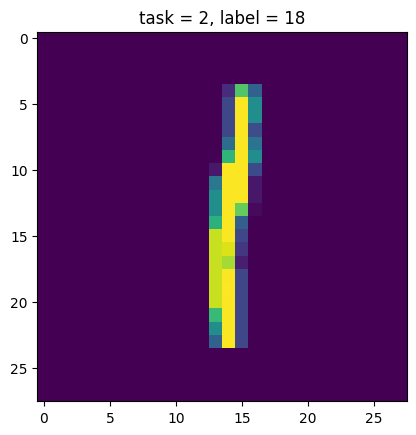

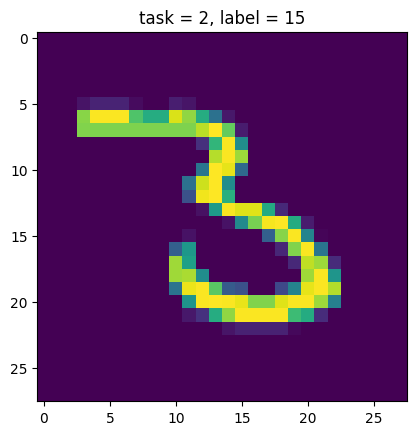

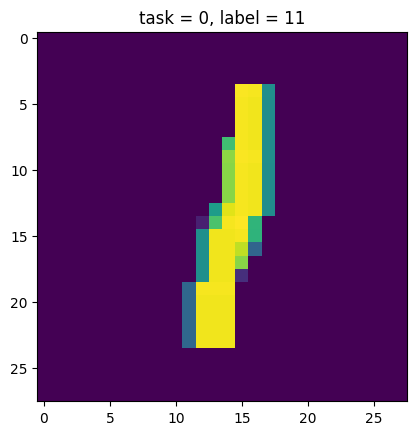

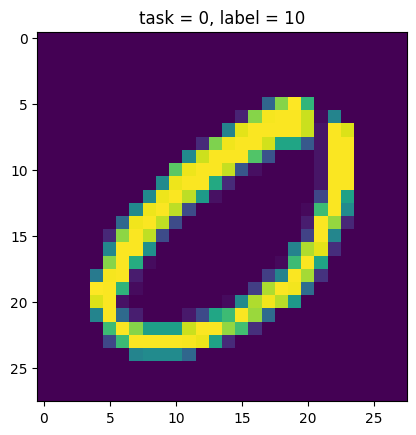

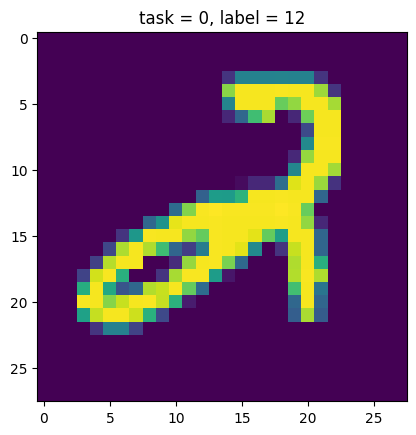

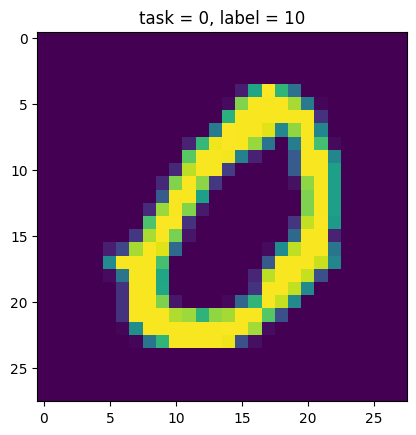

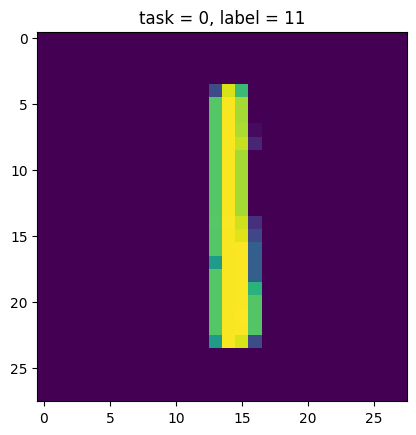

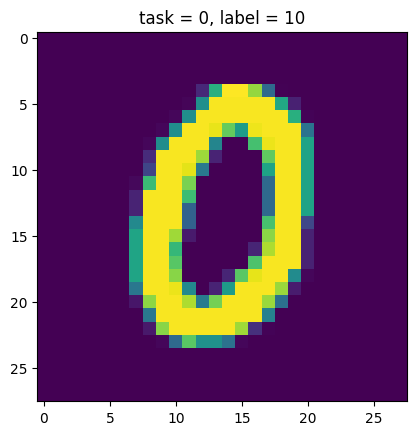

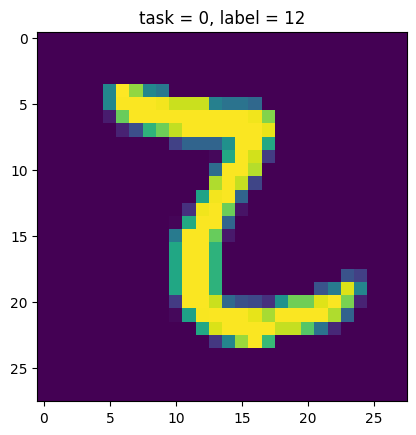

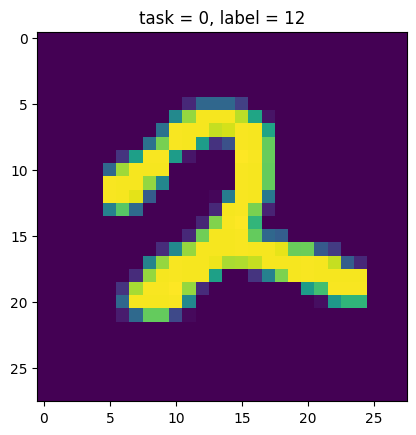

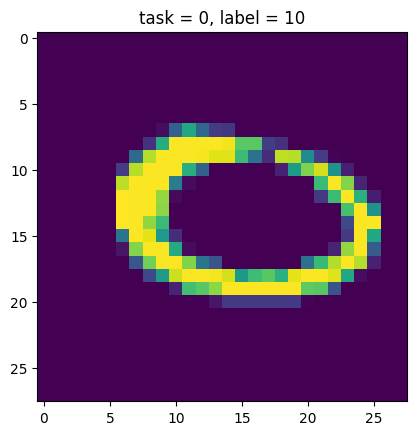

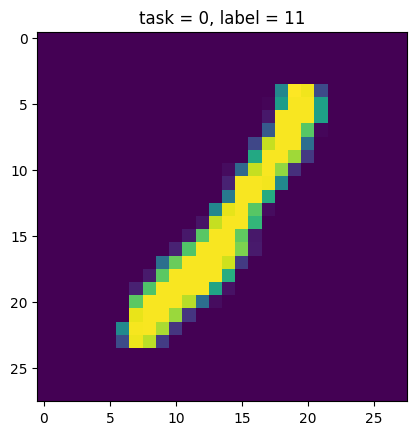

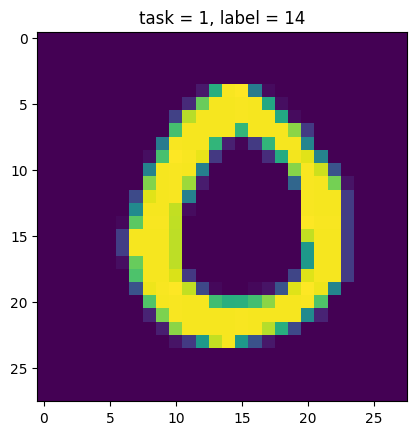

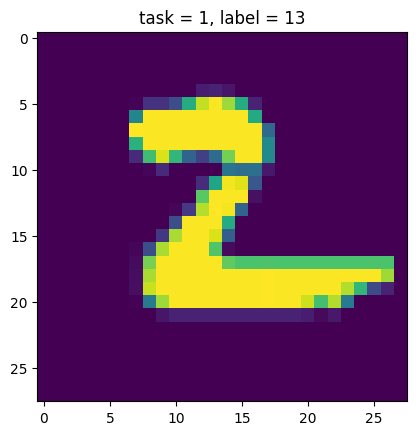

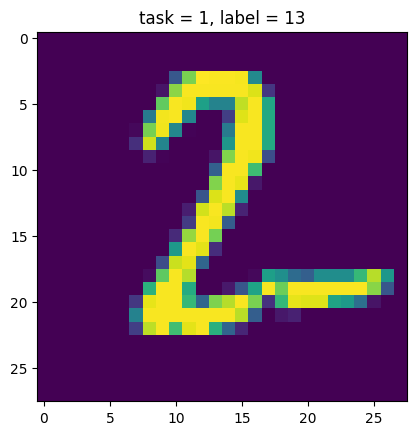

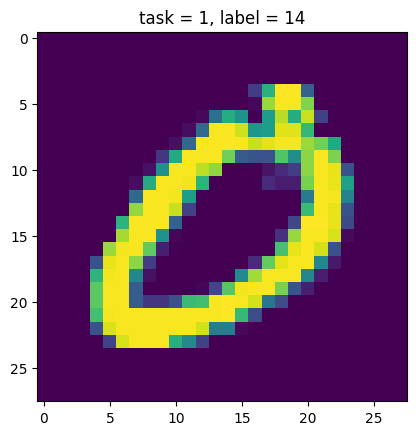

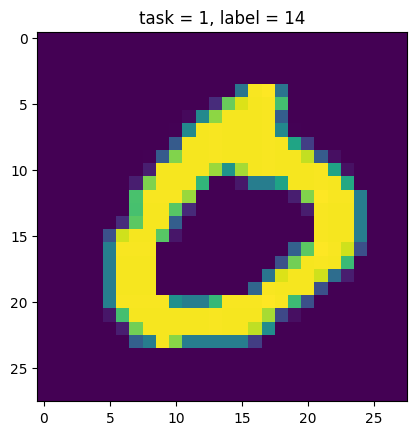

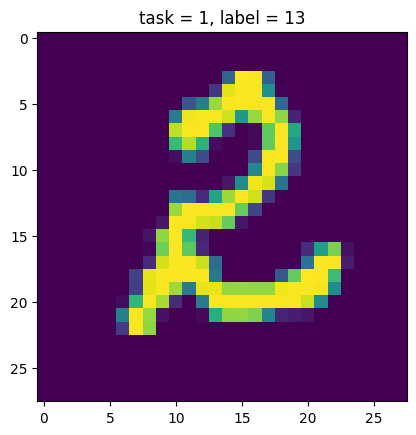

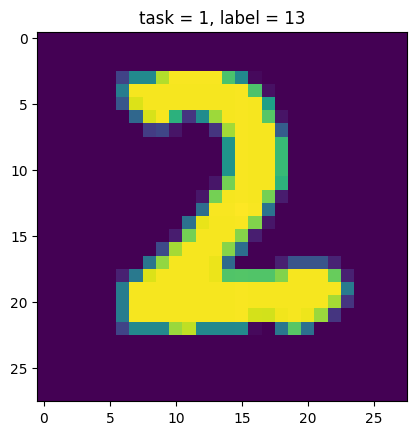

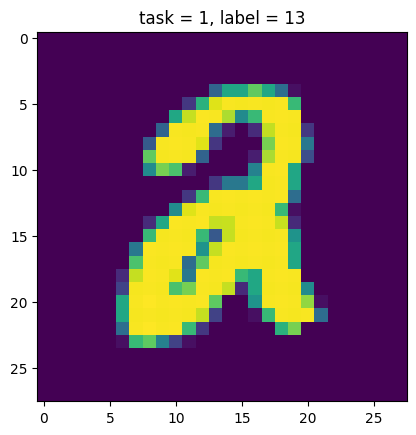

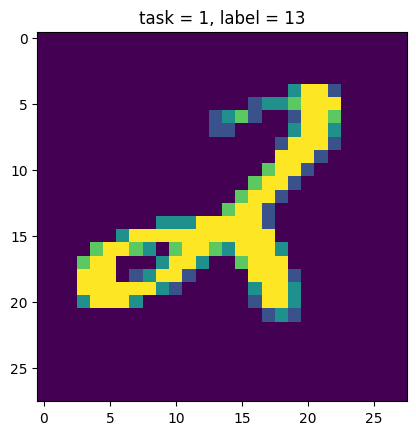

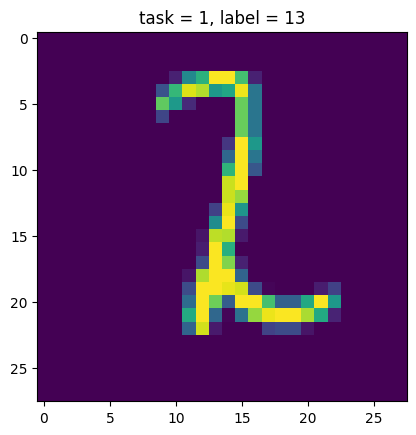

In [9]:
import matplotlib.pyplot as plt
for data, lab, taskid in zip(torch_dataset.data[seqInd[:50]], torch_dataset.targets[seqInd[:50]], pattern[:50]):
    plt.imshow(data.squeeze())
    plt.title(f'task = {taskid}, label = {lab}')
    plt.show()

## Markov

In [8]:
T = 5000
N = 10

tasks = [
    [0, 1, 2], [1, 2, 3], [2, 3, 4]
]

root = '../../data'
torch_dataset = get_torch_dataset(root, 'mnist')

tasklib, maplab, torch_dataset = get_multi_indices_and_map(tasks, torch_dataset)

In [9]:
num_tasks = len(tasks)
full_pattern = get_markov_chain(num_tasks, T, N, seed=1111)

In [10]:
train_seq, updated_tasklib = get_markov_sequence_indices(
    full_pattern,
    t=100,
    tasklib=tasklib,
    seed=1996,
    train=True
)

test_seq = get_markov_sequence_indices(
    full_pattern,
    t=100,
    tasklib=updated_tasklib,
    seed=1996,
    train=False
)

In [15]:
full_pattern[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
full_pattern[100:140]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
torch_dataset.targets[train_seq]

tensor([10, 10, 10, 10, 10, 12, 10, 11, 10, 12, 16, 17, 17, 18, 17, 16, 18, 18,
        17, 18, 12, 11, 11, 11, 10, 10, 11, 10, 11, 10, 10, 10, 10, 10, 11, 10,
        12, 10, 10, 11, 11, 11, 10, 12, 12, 10, 11, 10, 10, 11, 10, 12, 11, 11,
        12, 10, 10, 11, 10, 10, 11, 11, 12, 12, 11, 11, 10, 10, 10, 10, 15, 13,
        13, 13, 15, 15, 13, 15, 13, 13, 15, 14, 15, 13, 14, 13, 13, 13, 14, 15,
        15, 15, 13, 15, 14, 15, 15, 15, 15, 14])

In [22]:
torch_dataset.targets[test_seq][:40]

tensor([10, 10, 12, 11, 10, 11, 12, 10, 10, 10, 13, 13, 15, 13, 13, 13, 15, 13,
        15, 15, 15, 15, 15, 14, 15, 14, 15, 13, 14, 13, 10, 11, 10, 10, 10, 12,
        11, 11, 12, 10])

In [13]:
set(train_seq).intersection(set(test_seq))

set()

In [24]:
full_patterns = np.array([get_markov_chain(num_tasks, T, N, seed=k*1111) for k in range(3)])

In [122]:
T = 5000 # horizon
N = 10
num_tasks = len(tasks)
P = np.array([
    [0.2, 0.7, 0.1],
    [0.5, 0.3, 0.2],
    [0.3, 0.3, 0.4]
])

In [ ]:
initial_state_distro = np.array([1./num_tasks] * num_tasks)
state_distros = np.array([initial_state_distro.dot(np.linalg.matrix_power(P, l)) for l in range(T//N)])
pattern = np.array([np.random.choice(num_tasks, 1, p=state_distros[l]) for l in range(T//N)]).squeeze()
full_pattern = np.repeat(pattern, N)

In [118]:
t = 100
train = True
seed=1996

if train:
    pattern = full_pattern[:t]
else:
    pattern = full_pattern[t:]

tasklib = deepcopy(tasklib)
seqInd = np.zeros((t,)).astype('int')

np.random.seed(seed)
for taskid in range(num_tasks):
    seqInd[pattern==taskid] = np.random.choice(tasklib[taskid], sum(pattern==taskid), replace=False)

In [120]:
len(seqInd)

100